In [6]:
#import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder , OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.metrics import mean_absolute_error , mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
import joblib 

In [17]:

from sklearn.model_selection import StratifiedShuffleSplit

# 1. Load the dataset
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target

# 2. Create an income category column for stratification
# We bin 'MedInc' because stratify requires categorical data, not continuous floats
df["income_cat"] = pd.cut(df["MedInc"],
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])

# 3. Initialize the Stratified Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 4. Execute the split
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# 5. Remove the 'income_cat' column so the model doesn't use it as a feature
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 6. Separate Features (X) and Labels (y)
X_train = strat_train_set.drop("target", axis=1)
y_train = strat_train_set["target"].copy()

X_test = strat_test_set.drop("target", axis=1)
y_test = strat_test_set["target"].copy()

# Final Verification
print(f"Full dataset shape: {df.shape}")
print(f"X_train shape:      {X_train.shape}")
print(f"X_test shape:       {X_test.shape}")

Full dataset shape: (20640, 10)
X_train shape:      (16512, 8)
X_test shape:       (4128, 8)


In [19]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

# Identify numerical columns (all of them in this case)
num_attribs = list(X_train.columns)

# Create the preprocessing part
num_pipeline = Pipeline([
    ('scaler', RobustScaler()) # Handles outliers better than StandardScaler
])

# Combine preprocessing with the model
full_pipeline = Pipeline([
    ("preprocessing", num_pipeline),
    ("rf_reg", RandomForestRegressor(random_state=42))
])


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Updated param_grid (reduced numbers for faster testing)
param_grid = [
    {'rf_reg__n_estimators': [30, 100], 'rf_reg__max_features': [4, 6, 8]},
]
# 1. Update the GridSearchCV to use 'r2'
grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=5,
    scoring='r2',  # Changed to r2
    return_train_score=True
)

# 2. Fit the model
grid_search.fit(X_train, y_train)

# 3. Get the best R2 score from cross-validation
best_r2 = grid_search.best_score_
print(f"Best CV R2 Score: {best_r2:.4f}")

# 4. Evaluate on Test Set
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred)

print(f"Final Test R2 Score: {final_r2:.4f}")

Best CV R2 Score: 0.8118
Final Test R2 Score: 0.8209


In [28]:
y_pred[:20]

array([4.9118984, 2.1717405, 2.04154  , 1.71959  , 2.2144301, 1.64933  ,
       1.14357  , 4.3486622, 2.47341  , 2.8650509, 3.7354216, 0.69264  ,
       3.3035515, 2.9309601, 2.31156  , 1.40995  , 0.94836  , 1.09382  ,
       3.15119  , 3.9624308])

In [30]:
y_test[:20]

5241     5.00001
17352    1.62500
3505     2.04600
7777     1.59700
14155    1.84000
7057     1.51900
33       1.04900
17049    5.00001
18164    3.67400
10444    3.46500
4652     3.37000
16294    0.59200
16531    2.12500
18029    2.74600
3492     2.27100
13279    1.15800
1108     0.97600
2839     0.85500
7888     3.37400
8658     3.66200
Name: target, dtype: float64

In [31]:
residuals = y_test[:20] - y_pred[:20]
print(residuals)

5241     0.088112
17352   -0.546741
3505     0.004460
7777    -0.122590
14155   -0.374430
7057    -0.130330
33      -0.094570
17049    0.651348
18164    1.200590
10444    0.599949
4652    -0.365422
16294   -0.100640
16531   -1.178551
18029   -0.184960
3492    -0.040560
13279   -0.251950
1108     0.027640
2839    -0.238820
7888     0.222810
8658    -0.300431
Name: target, dtype: float64


In [25]:
import joblib

# Get the final tuned pipeline
final_model = grid_search.best_estimator_

# Save the model to a file
joblib.dump(final_model, 'california_housing_model.pkl')

print("Model saved successfully!")

Model saved successfully!


In [26]:
import joblib
import pandas as pd

# Load the saved model
loaded_model = joblib.load('california_housing_model.pkl')

# Example: Predicting on new, raw data
# Note: Data must be a DataFrame with the same column names as X_train
new_data = pd.DataFrame({
    'MedInc': [4.5],
    'HouseAge': [15.0],
    'AveRooms': [5.0],
    'AveBedrms': [1.0],
    'Population': [1200.0],
    'AveOccup': [3.0],
    'Latitude': [34.0],
    'Longitude': [-118.0]
})

prediction = loaded_model.predict(new_data)
print(f"Predicted House Value: ${prediction[0] * 100000:,.2f}")

Predicted House Value: $199,478.00


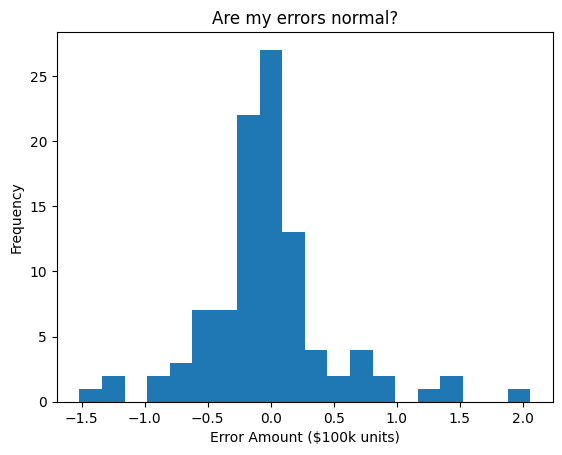

In [32]:
import matplotlib.pyplot as plt

# Calculate the errors
errors = y_test[:100] - y_pred[:100]

plt.hist(errors, bins=20)
plt.title("Are my errors normal?")
plt.xlabel("Error Amount ($100k units)")
plt.ylabel("Frequency")
plt.show()